In [ ]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

# Load and process MNIST data for image classification

#### Load the MNIST dataset. 

The MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. We use pixel values as features to build a neural network to predict the `digit` of an image. So there are 10 labels of this dataset, including "0", "1", "2", "3", "4", "5", "6", "7", "8", and "9".

Loading MNIST data of 70,000 images may take some time.

In [ ]:
#Convert the dataset into Tensor used by PyTorch
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the MINST data directly from PyTorch
#The downloaded datasets are stored in the same folder with this jupyter notebook file
#For train dataset, use "train=True"
#For test dataset, use "train=False"
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

#Load the datasets into DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']

The size of each image in MNIST data is 28x28. Different from multi-layer perceptron, each image is fed as 28x28 matrix to convolutional neural network directly

In [ ]:
#One batach has 64 images
dataiter = iter(train_dataloader)
samples = next(dataiter)
print(samples[0].shape)
print(samples[1].shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


#### Plot some MNIST examples

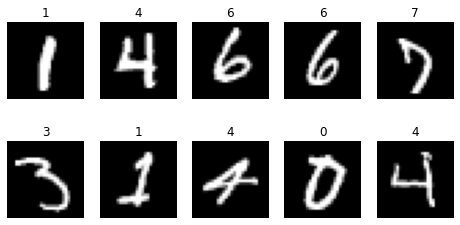

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plot the data
def plot_digits(instances, labels, images_per_row=5):
    for i in range(len(instances)):
        idx = i // images_per_row
        idy = i % images_per_row 
        ax[idx, idy].imshow(instances[i].squeeze(), cmap="gray")
        ax[idx, idy].set_title(class_names[labels[i]])
        ax[idx, idy].axis("off")

fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = samples[0][:10]
example_labels = samples[1][:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

# Use PyTorch to build a convolutional neural network for image classification

#### Define a class to construct all the layers in the convolutional neural network

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #1 input channel to 10 channels
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)#10 channels to 20 channels
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   #Use ReLU as activation function
        x = F.max_pool2d(x, 2)      #Apply max_pooling on the output of the convolution layer
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        #print("x shape: ", x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Set up some hyperparameters: use cross entropy loss, adam optimizer, and epochs

In [ ]:
epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

model = ClassificationNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

print(model)

ClassificationNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


#### Train the model

In [ ]:
#Define the training function
def train(epoch):
    model.train()
    
    running_loss = 0.0
    train_total, train_correct = 0.0, 0.0    
    y_train, y_pred = [], []
    
    for i, (features, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        outputs = model(features)

        loss = lossfunction(outputs, labels.long())
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels.long()).sum().item()
        y_train += labels.tolist()
        y_pred += train_predicted.tolist()
        
        if i % 200 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}'.format(
                epoch, i * len(features), len(train_dataloader.dataset),
                100. * i / len(train_dataloader), loss.item()))

    macro_f1 = f1_score(y_train, y_pred, average='macro')
    print("epoch (%d): Train accuracy: %.4f, f1_score: %.4f, loss: %.3f" % (epoch, train_correct/train_total, macro_f1, running_loss/train_total))
    
    
#Train the model
for epoch in range(1, epochs + 1):
    train(epoch)

Epoch: 1 [0/60000 (0%)]	loss: 2.322233
Epoch: 1 [12800/60000 (21%)]	loss: 0.084817
Epoch: 1 [25600/60000 (43%)]	loss: 0.045325
Epoch: 1 [38400/60000 (64%)]	loss: 0.147694
Epoch: 1 [51200/60000 (85%)]	loss: 0.033507
epoch (1): Train accuracy: 0.9501, f1_score: 0.9498, loss: 0.002
Epoch: 2 [0/60000 (0%)]	loss: 0.112441
Epoch: 2 [12800/60000 (21%)]	loss: 0.064210
Epoch: 2 [25600/60000 (43%)]	loss: 0.056033
Epoch: 2 [38400/60000 (64%)]	loss: 0.080379
Epoch: 2 [51200/60000 (85%)]	loss: 0.020791
epoch (2): Train accuracy: 0.9764, f1_score: 0.9762, loss: 0.001
Epoch: 3 [0/60000 (0%)]	loss: 0.153165
Epoch: 3 [12800/60000 (21%)]	loss: 0.047807
Epoch: 3 [25600/60000 (43%)]	loss: 0.026902
Epoch: 3 [38400/60000 (64%)]	loss: 0.122194
Epoch: 3 [51200/60000 (85%)]	loss: 0.053204
epoch (3): Train accuracy: 0.9768, f1_score: 0.9767, loss: 0.001
Epoch: 4 [0/60000 (0%)]	loss: 0.051344
Epoch: 4 [12800/60000 (21%)]	loss: 0.117959
Epoch: 4 [25600/60000 (43%)]	loss: 0.120933
Epoch: 4 [38400/60000 (64%)]	loss

# Evaluate the trained convolutional neural network

In [ ]:
#Define the test function
def test():
    model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for features, labels in test_dataloader:
            outputs = model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels.long()).sum().item()
            y_test += labels.tolist()
            y_pred += predicted.tolist()

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print('Test accuracy: %.4f, macro f1_score: %.4f' % (test_correct / test_total, macro_f1))
    
    return y_test, y_pred

#Test the model
y_test, y_pred = test()

Test accuracy: 0.9827, macro f1_score: 0.9826


#### Output the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[ 958    1    0    0    1    0   15    3    1    1]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   1    1 1001    4    3    0    1   10   11    0]
 [   0    1    3  997    0    4    0    2    3    0]
 [   0    2    0    0  970    0    1    1    0    8]
 [   1    0    1    7    0  872    4    1    4    2]
 [   2    3    1    0    1    1  949    0    1    0]
 [   0    9    3    0    3    1    0 1004    1    7]
 [   2    2    0    1    1    1    2    0  963    2]
 [   2    2    0    2   11    5    0    3    6  978]]


In [ ]:
import pandas as pd

pd.DataFrame(confusion, index=class_names, columns=class_names)

,0,1,2,3,4,5,6,7,8,9
0,958,1,0,0,1,0,15,3,1,1
1,0,1135,0,0,0,0,0,0,0,0
2,1,1,1001,4,3,0,1,10,11,0
3,0,1,3,997,0,4,0,2,3,0
4,0,2,0,0,970,0,1,1,0,8
5,1,0,1,7,0,872,4,1,4,2
6,2,3,1,0,1,1,949,0,1,0
7,0,9,3,0,3,1,0,1004,1,7
8,2,2,0,1,1,1,2,0,963,2
9,2,2,0,2,11,5,0,3,6,978


#### Calculate accuracy, macro F1-score, and micro F1-score

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_test, y_pred)
macrof1 = f1_score(y_test, y_pred, average='macro')
microf1 = f1_score(y_test, y_pred, average='micro')
print('Accuracy: {:.2f}'.format(acc))
print('Macro F1-score: {:.2f}'.format(macrof1))
print('Micro F1-score: {:.2f}'.format(microf1))

Accuracy: 0.98
Macro F1-score: 0.98
Micro F1-score: 0.98


# Adversarial Attacks with Fast Gradient Sign Method (FGSM)

#### Define FGSM attack function
adv_x = 𝒙 + 𝜀 * 𝐬𝐢𝐠𝐧(𝜵𝒙𝐿𝑜𝑠𝑠(𝑥,𝑦,𝑤))

In [ ]:
def fgsm_attack(image, epsilon, image_input_grad):
    #Obtain the sign of the gradient
    sign_grad = image_input_grad.sign()
    
    #Generate the perturbed image by adding the perturbation with size of epsilon and direction of gradient to the input image
    perturbed_image = image + epsilon * sign_grad
    perturbation = epsilon * sign_grad
    
    #Each pixel value's range is [0,1]
    #After performing adversarial attack, the pixel values may go out of boundary
    #Add clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    #Return the perturbed image
    return perturbed_image, perturbation

#### Calculate gradient of loss function with respect to the input image, get the sign of gradient, and then pass it to fgsm_attack() function to generate the adversarial example

In [ ]:
def perform_attack(epsilon, image_input, image_label):
    #Set requires_grad attribute of tensor as true, which will be used for Attack
    image_input.requires_grad = True

    output = model(image_input)

    init_pred = output.max(1, keepdim=True)[1]

    if init_pred.item() != image_label.item():
        print("The predicted label and the true label are different. Please choose another image input for attack!")

    #Calculate the loss
    loss = lossfunction(output, image_label.long())

    # Zero all existing gradients
    model.zero_grad()

    #Calculate gradients of loss in backward pass
    loss.backward()

    #Obtain the gradient regarding input image
    image_input_grad = image_input.grad.data

    # Call FGSM attack
    perturbed_image, perturbation = fgsm_attack(image_input, epsilon, image_input_grad)

    # Re-classify the perturbed image
    adv_output = model(perturbed_image)

    adv_pred = adv_output.max(1, keepdim=True)[1]

    return perturbed_image, perturbation, init_pred, adv_pred

#### Given an input image, use different epsilons to see their impacts on the attack effectiveness and classification result

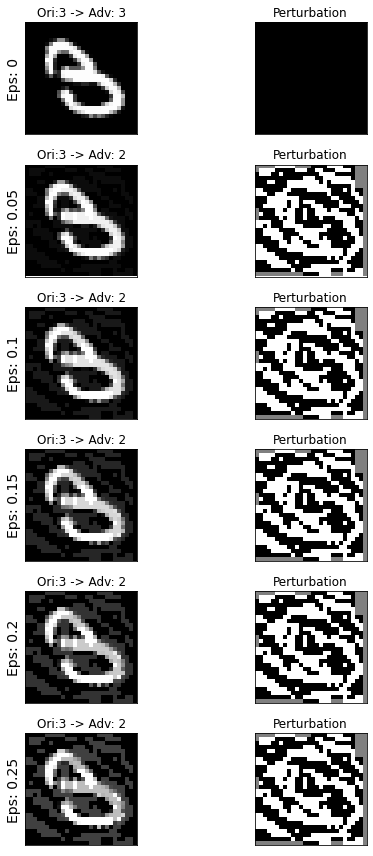

In [ ]:
#epsilons
epsilons = [0, .05, .1, .15, .2, .25]

#Choose a random image as input
image_sample_index = 18

dataiter = iter(test_dataloader)
samples = dataiter.next()
image_input, image_label = samples[0][image_sample_index:image_sample_index+1], samples[1][image_sample_index:image_sample_index+1]

adversarial_examples = []
adv_preds = []
init_preds = []
perturbations = []

for epsilon in epsilons:
    perturbed_image, perturbation, init_pred, adv_pred = perform_attack(epsilon, image_input, image_label)
    adversarial_examples.append(perturbed_image.squeeze().detach().numpy())
    adv_preds.append(adv_pred.item())
    init_preds.append(init_pred.item())
    perturbations.append(perturbation.squeeze().detach().numpy())

#Plot adversarial example and the perturbation at each epsilon
cnt = 0
plt.figure(figsize=(8,12))
for i in range(len(epsilons)):
    cnt = 2 * i + 1 
    plt.subplot(len(epsilons), 2, cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
    orig, adv, ex = init_preds[i], adv_preds[i], adversarial_examples[i] 
    plt.title("Ori:{} -> Adv: {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
    
    plt.subplot(len(epsilons), 2, cnt+1)
    plt.xticks([], [])
    plt.yticks([], [])
    perturbation = perturbations[i] 
    plt.title("Perturbation".format(orig, adv))
    plt.imshow(perturbation, cmap="gray")
plt.tight_layout()
plt.show()